# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
import datetime
import math
import nltk
import string
import re


from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB 
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)



import warnings
warnings.filterwarnings('ignore')

---

# 1. Pre-processing text data

In [2]:
# import dataset that has been cleaned in Project_3b
df_combined = pd.read_csv('../data/df_for_modelling_top2500.csv')
df_combined = df_combined.drop(columns='Unnamed: 0')

## 1a. Converting target variable subreddit into 0 and 1 binary form

In [3]:
df_combined['subreddit'].replace({'news':1,
                                 'TheOnion':0}, inplace=True)

### Steps to pre-process text data:
1. remove punctuations
2. tokenize
3. remove stopwords
4. stem / lemmatize

We will create a function `clean_text` to do all the above steps

In [4]:
stopword = nltk.corpus.stopwords.words('english')
puncts = string.punctuation
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()

In [5]:
# function to clean text data so that it can be ready for modelling
def clean_text(text):
    # create numberlist
    mylist=[]
    for i in list(range(0,10)):
        mylist.append(str(i))
    
    # 1. remove punctuations only
    title = ''.join([char for char in text if (char not in puncts)])
    # 1b. remove punctuations and numbers
#     title = ''.join([char for char in text if (char not in puncts) and (char not in mylist)])
    
    # 2. tokenize
    my_list = re.split('\W+', title)
    my_list = list(filter(None, my_list))
    # 3. remove stop word
    my_list = [char.lower() for char in my_list if char.lower() not in stopword]
    # 4. lemmatize
    my_list = [wn.lemmatize(word) for word in my_list]
    
    return my_list

## Defining functions that will be used later on

In [6]:
# function to plot heatmap with the current X_train, y_train, y_test, y_pred
# this will be used throughout

def plot_cm(title:str, clf):
    
    fig ,ax = plt.subplots(1,2, figsize=(10,5))
    fig.suptitle(("Confusion Matrix \n" + str(title)), fontsize=20)
    fig.tight_layout(pad = 3)

    sns.heatmap(
        confusion_matrix(y_train, clf.predict(X_train)),
        annot= True,
        square = True,
        linecolor= "Black",
        linewidths=1,
        ax=ax[0],
        fmt='g',
        cmap ='Blues',
        annot_kws={"size": 15},
        cbar=False

    )
    ax[0].set_title("Train Set", fontsize=15);
    ax[0].set_xlabel("Predicted", fontsize=13);
    ax[0].set_ylabel("Actual", fontsize=13);
    ax[0].set_xticklabels(['r/TheOnion','r/news'], fontsize=10)
    ax[0].set_yticklabels(['r/TheOnion','r/news'], fontsize=10)


    sns.heatmap(
        confusion_matrix(y_test, y_pred),
        annot= True,
        square = True,
        linecolor= "Black",
        linewidths=1,
        ax=ax[1],
        fmt='g',
        cmap ='BuGn',
        annot_kws={"size": 15},
        cbar=False
    )
    ax[1].set_title("Test Set", fontsize=15);
    ax[1].set_xlabel("Predicted", fontsize=13);
    ax[1].set_ylabel("Actual", fontsize=13);
    ax[1].set_xticklabels(['r/TheOnion','r/news'], fontsize=10)
    ax[1].set_yticklabels(['r/TheOnion','r/news'], fontsize=10);


In [7]:
# function to plot barplot of vectorizing results

def plot_word_freq(X_counts, vectorizer, num_rows, name=""):
    '''
    vectorizer : count_vect or tfidf_vect
    name : name of vectorizer
    num_rows : num of rows to plot
    '''
    scale = num_rows/25
    # Converting ngram results into dataframe
    df = pd.DataFrame(X_counts.toarray())
    df.columns = vectorizer.get_feature_names()
    # adding up sum of occurences for each bigram words
    df_2 = pd.DataFrame(df.sum()).reset_index()
    df_2.columns =['word', 'frequency of occurence']
    # sorting bigram words in descending order
    df_2.sort_values(by='frequency of occurence', ascending=False, inplace=True)
    # plotting bar chart to visualise frequency of words
    x = df_2[df_2['frequency of occurence']>2]

    plt.figure(figsize=(14*(scale),8*(scale)))
    sns.barplot(df_2['frequency of occurence'][0:num_rows],df_2['word'][0:num_rows], orient='h')
    plt.xticks(rotation = 80);
    plt.title('Top ' + str(num_rows) + '\nwords with highest ' + str(name) + ' scores', fontsize=15);

___

## 1b. Vectorizing textual data using 3 methods, followed by modelling
1. CountVectorizer
    - Multinomial Naive Bayes
    - Bernoulli Naive Bayes
2. N-Grams
    - Multinomial Naive Bayes
    - Bernoulli Naive Bayes
3. TF-IDF
    - Multinomial Naive Bayes
    - Bernoulli Naive Bayes
    
We will use Pipeline and GridSearchCV to run these variations and decide on the best model

___

The below graph shows the frequency of each words appearing based on TF-IDF vectorizer.

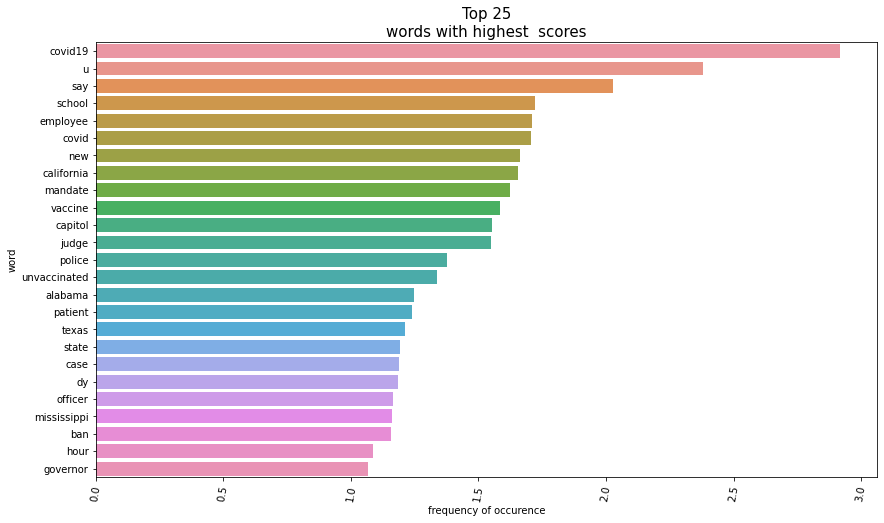

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df_combined['title'], df_combined['subreddit'], 
                                                    test_size=0.2, random_state=24)
tvec = TfidfVectorizer(analyzer=clean_text)
X_counts = tvec.fit_transform(df_combined['title'][0:100])
X_counts.shape

plot_word_freq(X_counts, tvec, 25)

___

# 2. Modeling

## 2a. Modeling - Pipeline
- We will use GridSearchCV to iterate through various vectorizers and classifiers with their respective hyperparameters, all within the pipeline. 
    1. vectorize text using 2 methods:
        - Count Vectorizer
        - TF-IDF Vectorizer
    2. classify vectorized data using 3 methods:
        - Logistic Regression
        - K-Nearest Neighbors
        - Naive Bayes
- We will then evaluate each scores and determine the best estimators with the corresponding hyperparameters 

In [9]:
a= time.time()

# Setting train test split before vectorizing and modelling
X_train, X_test, y_train, y_test = train_test_split(df_combined['title'], df_combined['subreddit'], 
                                                    test_size=0.2, random_state=24)

# setting the hyperparameters to be tuned during the GridSearchCv
grid_params = [
    {
        'vec__max_df': [1.0,0.95],
        'vec__min_df': [0.0,0.05],
        'vec__ngram_range': [(1,3)],
        'vec__max_features': [5000,6000],
    },

    {
        'clf': [LogisticRegression()],
        'clf__penalty':['l2','l1'],
        'clf__C':[1,5,10,15],
        'clf__l1_ratio':[0.25,0.5,0.75],
    },
    
    {
        'clf': [LogisticRegression()],
        'clf__penalty':['l2'],
        'clf__C':[1,5,10,15],
        'clf__l1_ratio':[0.25,0.5,0.75],
        'clf__solver':['newton-cg','saga','sag','liblinear']
    },
    
    {
        'clf': [KNeighborsClassifier()],
        'clf__n_neighbors':[3,5,7],
        'clf__weights':['uniform','distance'],
        'clf__algorithm':['ball_tree','kd_tree','auto']
    },
    
    {
        'clf': [MultinomialNB()],
        'clf__alpha':[0,0.5,1,1.5,2,3,4],        
    },
]

# we do a for loop to loop through the 2 types of vectorizers
# and use GridSearchCV to iterate the model through various hyperparameters
# the best model will be selected based on highest accuracy score
best_score = 0
vec_list = [CountVectorizer(analyzer=clean_text), TfidfVectorizer(analyzer=clean_text)]

# creating a list for tracking of best scores/models/params thru each loop
score = []
model = []
params =[]
vect = []

# lopp thru each of the 2 vectorizers
for vec in vec_list: 
    pipe = Pipeline([
        ('vec', vec),
        ('clf', LogisticRegression())
    ])


    # iterate thru the different grid_params for each model for the current vectorizer
    for i in range(1,len(grid_params)):
        gridsearch = GridSearchCV(pipe, grid_params[i], verbose=1, n_jobs=-1,
                              cv=5, return_train_score=False)
        gridsearch.fit(X_train,y_train)
        y_pred = gridsearch.predict(X_test)
        
        # appending list of scores for each model for tracking purposes
        model.append(grid_params[i]['clf'][0])
        score.append(gridsearch.best_score_)
        params.append(gridsearch.best_params_)
        vec_name = (re.findall('(\w+)\(',str(vec)))[0]
        vect.append(vec_name)
    
    
    # printing each model with its vectorizer and respective scores
    score = list(np.round(score,3))
    vec_name = (re.findall('(\w+)\(',str(vec)))[0]
    print("\nHere are the lists of best scores from {} for each model :\n".format(vec_name))
    
    for i in range(len(model)):
        model_name = (re.findall('(\w+)\(',str(model[i])))[0]
        print(f"{model_name}: {score[i]}\nWith best parameters: {params[i]}")
        print("\n")

        
    # retain gridsearch pipeline with the best score for later use
    if gridsearch.best_score_ > best_score:
        best_score = gridsearch.best_score_
        best_params = gridsearch.best_params_
        best_estimator = gridsearch.best_estimator_
        gridsearch = gridsearch
        y_pred = y_pred
    
        
b= time.time()
print(b-a)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits

Here are the lists of best scores from CountVectorizer for each model :

LogisticRegression: 0.87
With best parameters: {'clf': LogisticRegression(C=1, l1_ratio=0.25), 'clf__C': 1, 'clf__l1_ratio': 0.25, 'clf__penalty': 'l2'}


LogisticRegression: 0.87
With best parameters: {'clf': LogisticRegression(C=1, l1_ratio=0.25, solver='newton-cg'), 'clf__C': 1, 'clf__l1_ratio': 0.25, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg'}


KNeighborsClassifier: 0.586
With best parameters: {'clf': KNeighborsClassifier(algorithm='ball_tree', n_neighbors=3, weights='distance'), 'clf__algorithm': 'ball_tree', 'clf__n_neighbors': 3, 'clf__weights': 'distance'}


MultinomialNB: 0.882
With best parameters: {'clf': MultinomialNB(alpha=0.5), 'clf__alpha': 0.5}


Fit

In [10]:
df_gridsearch = pd.DataFrame([vect,model,score,params]).T
df_gridsearch.columns=['Vectorizer','Model','Accuracy score','Hyperparameters']
df_gridsearch.Model = df_gridsearch.Model.map(lambda x: (re.findall('(\w+)\(',str(x)))[0])

**The table below shows the best hyperparameters for each permutation of Vectorizer and Model/Estimator. 
df_gridsearch**

In [11]:
df_gridsearch

,Vectorizer,Model,Accuracy score,Hyperparameters
0,CountVectorizer,LogisticRegression,0.87,"{'clf': LogisticRegression(C=5, l1_ratio=0.25), 'clf__C': 1, 'clf__l1_ratio': 0.25, 'clf__penalty': 'l2'}"
1,CountVectorizer,LogisticRegression,0.87,"{'clf': LogisticRegression(C=5, l1_ratio=0.25, solver='newton-cg'), 'clf__C': 1, 'clf__l1_ratio': 0.25, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg'}"
2,CountVectorizer,KNeighborsClassifier,0.586,"{'clf': KNeighborsClassifier(algorithm='ball_tree', n_neighbors=7, weights='distance'), 'clf__algorithm': 'ball_tree', 'clf__n_neighbors': 3, 'clf__weights': 'distance'}"
3,CountVectorizer,MultinomialNB,0.882,"{'clf': MultinomialNB(alpha=1), 'clf__alpha': 0.5}"
4,TfidfVectorizer,LogisticRegression,0.879,"{'clf': LogisticRegression(C=5, l1_ratio=0.25), 'clf__C': 5, 'clf__l1_ratio': 0.25, 'clf__penalty': 'l2'}"
5,TfidfVectorizer,LogisticRegression,0.879,"{'clf': LogisticRegression(C=5, l1_ratio=0.25, solver='newton-cg'), 'clf__C': 5, 'clf__l1_ratio': 0.25, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg'}"
6,TfidfVectorizer,KNeighborsClassifier,0.798,"{'clf': KNeighborsClassifier(algorithm='ball_tree', n_neighbors=7, weights='distance'), 'clf__algorithm': 'ball_tree', 'clf__n_neighbors': 7, 'clf__weights': 'distance'}"
7,TfidfVectorizer,MultinomialNB,0.883,"{'clf': MultinomialNB(alpha=1), 'clf__alpha': 1}"


___

## 2b. Evaluation of GridSearchCV results

As shown in the scores above, we found the best pipeline model to be:
- TF-IDF Vectorizer
- Multinomial Naive Bayes with hyperparameter alpha value of 1.

### Score metrics based on the best model
- i.e. TF-IDF Vectorizer with Multinomial Naive Bayes (alpha = 1)
- **Take note that the scores below are not mean value, while the scores by GridSearchCV (shown above) are the mean values for cv=5**

In [12]:
# train set scores
train_f1 = f1_score(y_train,gridsearch.predict(X_train))
train_acc = accuracy_score(y_train,gridsearch.predict(X_train))
train_prec = precision_score(y_train,gridsearch.predict(X_train))
train_rec =recall_score(y_train,gridsearch.predict(X_train))

# test set scores
test_f1 = f1_score(y_test,y_pred)
test_acc  = accuracy_score(y_test,y_pred)
test_prec = precision_score(y_test,y_pred)
test_rec  = recall_score(y_test,y_pred)

# creating dataframe to visualize the different classification metric scores for our optimized model
df_results = pd.DataFrame(
                columns = ["F1 score", "Accuracy score", "Precision score", "Recall score"],
                index = ['train', 'test']
)

df_results.loc['train'] = [train_f1, train_acc, train_prec,train_rec]
df_results.loc['test'] = [test_f1, test_acc, test_prec, test_rec]
df_results

,F1 score,Accuracy score,Precision score,Recall score
train,0.969606,0.96975,0.965483,0.973764
test,0.898551,0.895,0.89942,0.897683


The above table shows the train and test scores for our best model. Take note that these scores are slightly different from the one generated by the Pipeline GridSearchCV since the latter is a mean value of cv=5, while there is no cross-validation on the former.

### Confusion matrix for best model

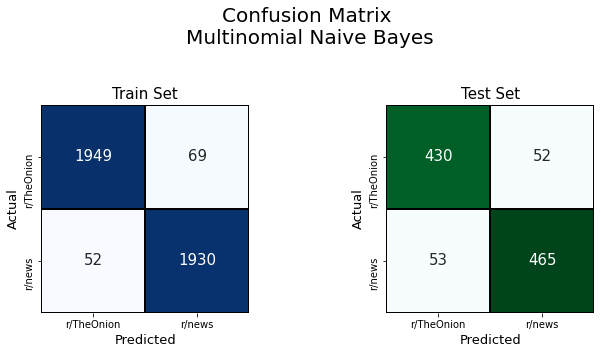

In [13]:
plot_cm("Multinomial Naive Bayes", gridsearch)

For our use case of detecting fake news, we want to maximise the metric `specificity`. 
- we want to maximise the number of True Negative (i.e. correctly detecting fake news as fake)
- we want to minimise the number of False Positive (i.e. wrongly detecting fake news as real)

Therefore, from the above confusion matrix perspective, we want to:
- increase the top left number
- decrease the bottom left number

From the looks of it, our model is doing very well in this regards, achieving specificity of 0.892 on the test set. This means, for every 1000 fake news, our model will correctly detect 892 of it as fake. 

**Specificity score comparison:**
- Multinomial Naive Bayes: 0.892
- Logistic Regression: 0.923
- KNN : 0.653


While the specificity score of Logistic Regression is highest, we still selected Multinomial Naive Bayes based on the other metrics scores in which it scored better. The best compromise score would be the F1-score, in which our model again did very well with 0.894 vs 0.885 for Logistic Regression. Also, the Logistic Regression seem to have overfitted more in the train set, as compared to Multinomial Naive Bayes.

**F1-score comparison:**
- Multinomial Naive Bayes: 0.894
- Logistic Regression: 0.885
- KNN :0.808


**Just as comparison to the best Logistic Regression model**

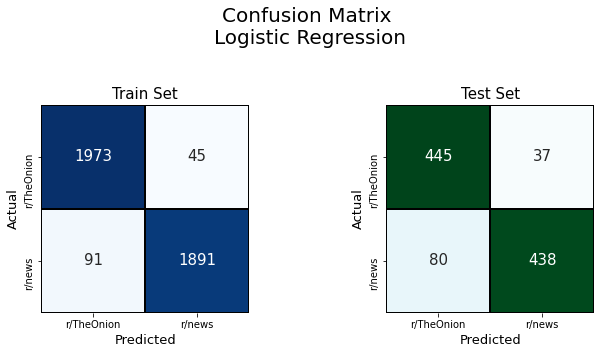

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_combined['title'], df_combined['subreddit'], 
                                                    test_size=0.2, random_state=24)
tvec = TfidfVectorizer(analyzer=clean_text)
X_train = tvec.fit_transform(X_train)
X_test = tvec.transform(X_test)
clf = LogisticRegression()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

plot_cm("Logistic Regression", clf)

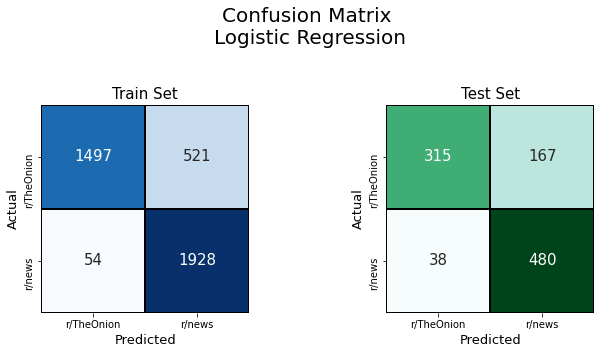

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_combined['title'], df_combined['subreddit'], 
                                                    test_size=0.2, random_state=24)
tvec = TfidfVectorizer(analyzer=clean_text)
X_train = tvec.fit_transform(X_train)
X_test = tvec.transform(X_test)
clf = KNeighborsClassifier()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

plot_cm("Logistic Regression", clf)

___

# Hyperparameter Tuning


- While the Pipeline and GridSearchCV helped to automate and extract the best hyperparameters, we will just have a look at how the alpha hyperparameter value affects the Multinomial Naive Bayes model.
- Alpha value refers to the Laplace Smoothing. It assigns a non-zero probability to words that do not appear in a particular classification. For example, we cannot say that a particular word (say "covid") will never appear in r/news just because it did not appear in our sample. Therefore alpha value is applied to counter this effect. 
- Thru gridsearchcv, we found that the optimal value was 1.
- As the value increases beyond 1, the score drops, this is because as alpha increases, the model will rely too heavily on the alpha value instead of the actual probability of each word. And therefore it becomes very biased and hence inaccurate.

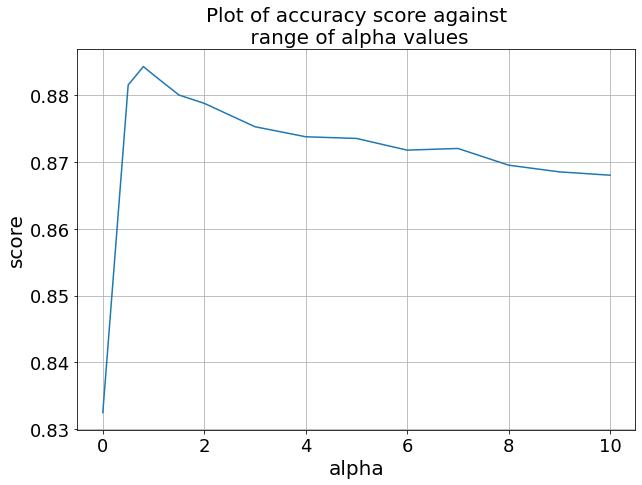

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_combined['title'], df_combined['subreddit'], 
                                                    test_size=0.2, random_state=24)
tvec = TfidfVectorizer(analyzer=clean_text)
X_train = tvec.fit_transform(X_train)
X_test = tvec.transform(X_test)

alpha_range = [0,0.5,0.8,1,1.5,2,3,4,5,6,7,8,9, 10]
scores = []
for alpha in alpha_range:
    clf = MultinomialNB(alpha=alpha)
    clf.fit(X_train, y_train)
    score = cross_val_score(clf, X_train,y_train, cv=5).mean()
#     print(score)
    scores.append(score)

plt.figure(figsize = (10,7))
plt.plot(alpha_range, scores);

plt.xlabel('alpha', fontsize =20);
plt.ylabel('score', fontsize = 20);
plt.title("Plot of accuracy score against\n range of alpha values", fontsize =20)
plt.tick_params(labelsize = 18)
plt.grid()

___